# Visualizing results from ensembling

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [13]:
# Load the CSV file generated from gradCAM_ensemble
df = pd.read_csv('results.csv')
#df = df.dropna()

# Display the first few rows of the DataFrame
print(df)

       True Label  Classes1  Classes2  Classes3  Classes4  Num Peaks RESNET50  \
0               0         1         2         2         2                   8   
1               0         2         2         2         1                   8   
2               0         2         2         2         2                  10   
3               0         1         1         2         2                   4   
4               0         2         2         2         2                   9   
...           ...       ...       ...       ...       ...                 ...   
12212           2         2         0         2         2                   1   
12213           2         2         2         2         2                   2   
12214           2         2         2         2         2                   1   
12215           2         0         1         2         1                   9   
12216           2         0         0         0         2                   6   

       Num Peaks RESNET18  

In [10]:
# Step 1: Define correlation columns
corr_columns = ['corr_1_2', 'corr_1_3', 'corr_1_4', 'corr_2_3', 'corr_2_4', 'corr_3_4']

# Step 2: Filter rows based on correlation values
greater_than_05_df = df[df[corr_columns].gt(0.5).any(axis=1)]  # Rows with at least one correlation > 0.5
not_greater_than_05_df = df[~df[corr_columns].gt(0.5).any(axis=1)]  # Rows with no correlation > 0.5

# Print the new DataFrames to see the filtered results
print("Rows with at least one correlation value greater than 0.5:")
print(greater_than_05_df)

print("\nRows with no correlation values greater than 0.5:")
print(not_greater_than_05_df)

Rows with at least one correlation value greater than 0.5:
       True Label  Classes1  Classes2  Classes3  Classes4  Num Peaks RESNET50  \
0               0         1         2         2         2                   8   
1               0         2         2         2         1                   8   
3               0         1         1         2         2                   4   
4               0         2         2         2         2                   9   
5               0         2         2         2         2                   9   
...           ...       ...       ...       ...       ...                 ...   
12205           2         2         2         2         2                   1   
12206           2         2         2         2         1                   1   
12208           2         0         0         0         2                   8   
12213           2         2         2         2         2                   2   
12216           2         0         0         0   

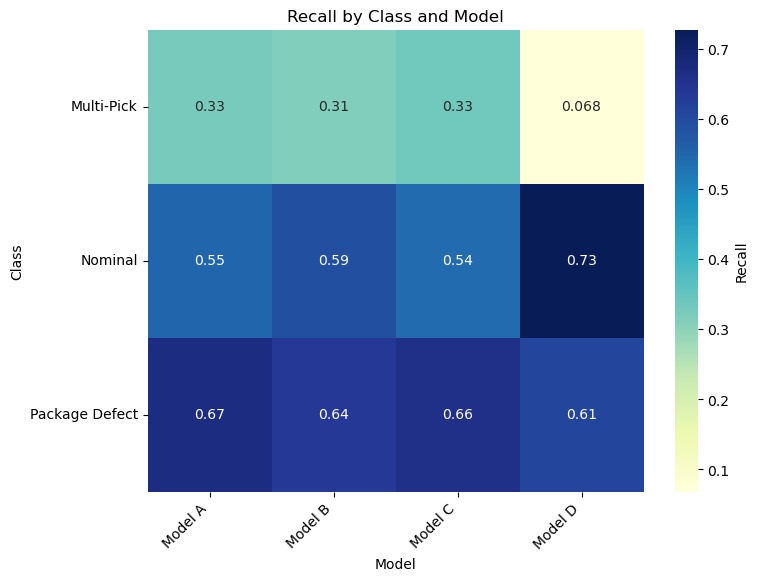

In [14]:
# Initialize list to store recall values
recalls = []

for model in ['Classes1', 'Classes2', 'Classes3', 'Classes4']:
    # Get the true labels and predictions
    y_true = df['True Label']
    y_pred = df[model]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # Assuming classes are 0, 1, 2

    # Extract TP and FN for each class
    for cls in range(3):  # Adjust based on the number of classes
        tp = cm[cls, cls]  # True Positives
        fn = cm[cls].sum() - tp  # False Negatives
        # Recall = TP / (TP + FN)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recalls.append((model, cls, recall))

# Create a DataFrame for recall values
recall_df = pd.DataFrame(recalls, columns=['Model', 'Class', 'Recall'])

# Pivot the DataFrame for easier plotting
recall_pivot = recall_df.pivot(index='Class', columns='Model', values='Recall')

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(recall_pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Recall'})

# Custom labels for axes
custom_x_labels = ['RESNET 50', 'RESNET 18', 'RESNET 101', 'DEiT']  # Replace with your model names
custom_y_labels = ['Multi-Pick', 'Nominal', 'Package Defect']  # Replace with your class names

# Set custom ticks
heatmap.set_xticklabels(custom_x_labels, rotation=45, ha='right')
heatmap.set_yticklabels(custom_y_labels, rotation=0)

plt.title('Recall by Class and Model')
plt.show()

In [ ]:
# Assuming df is your DataFrame

# Step 1: Define correlation columns
corr_columns = ['corr_1_2', 'corr_1_3', 'corr_1_4', 'corr_2_3', 'corr_2_4', 'corr_3_4']

# Step 2: Function to determine classes based on max correlation
def get_classes_from_max_corr(row):
    max_corr_name = row[corr_columns].idxmax()  # Get the name of the column with the max value
    corr_mapping = {
        'corr_1_2': ('Classes1', 'Classes2'),
        'corr_1_3': ('Classes1', 'Classes3'),
        'corr_1_4': ('Classes1', 'Classes4'),
        'corr_2_3': ('Classes2', 'Classes3'),
        'corr_2_4': ('Classes2', 'Classes4'),
        'corr_3_4': ('Classes3', 'Classes4')
    }
    return corr_mapping[max_corr_name]

# Step 3: Apply function to get classes based on max correlation
df['classes'] = df.apply(get_classes_from_max_corr, axis=1)

# Step 4: Define consensus function
def consensus(row):
    classes_a, classes_b = row['classes']
    if row[classes_a] == row[classes_b]:
        if row[classes_a] == row['True Label']:
            return 1  # Accurate prediction
    return 0  # Not accurate prediction

# Step 5: Apply consensus function and create new columns
df['multi_pick_consensus'] = df.apply(consensus, axis=1)
df['nominal_consensus'] = df.apply(consensus, axis=1)
df['package_defect_consensus'] = df.apply(consensus, axis=1)

# Print the DataFrame to see the new columns
print(df.head())


In [15]:
# Step 1: Define correlation columns
corr_columns = ['corr_1_2', 'corr_1_3', 'corr_1_4', 'corr_2_3', 'corr_2_4', 'corr_3_4']

# Step 2: Filter rows where at least 4 correlation values are positive
positive_corr_df = df[df[corr_columns].gt(0).sum(axis=1) >= 4]

# Print the new DataFrame to see the filtered results
print(positive_corr_df)

       True Label  Classes1  Classes2  Classes3  Classes4  Num Peaks RESNET50  \
0               0         1         2         2         2                   8   
2               0         2         2         2         2                  10   
13              0         1         2         1         2                   6   
14              0         2         2         2         2                   8   
22              0         0         2         2         1                   1   
...           ...       ...       ...       ...       ...                 ...   
12202           2         2         2         2         2                   2   
12203           2         2         2         2         2                   1   
12208           2         0         0         0         2                   8   
12212           2         2         0         2         2                   1   
12216           2         0         0         0         2                   6   

       Num Peaks RESNET18  

In [16]:
positive_corr_df.shape

(4286, 15)

In [ ]:
# Load the CSV file
df = pd.read_csv('results/ensembled_results.csv')
#df = df.dropna()

# Display the first few rows of the DataFrame
print(df)

# Initialize list to store recall values
recalls = []

# Compute recall for each model
for model in ['Classes1', 'Classes2', 'Classes3']: #, 'Classes4']:
    # Get the true labels and predictions
    y_true = df['True Label']
    y_pred = df[model]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # Assuming classes are 0, 1, 2

    # Extract TP and FN for each class
    for cls in range(3):  # Adjust based on the number of classes
        tp = cm[cls, cls]  # True Positives
        fn = cm[cls].sum() - tp  # False Negatives
        # Recall = TP / (TP + FN)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recalls.append((model, cls, recall))

# Create a DataFrame for recall values
recall_df = pd.DataFrame(recalls, columns=['Model', 'Class', 'Recall'])

# Pivot the DataFrame for easier plotting
recall_pivot = recall_df.pivot(index='Class', columns='Model', values='Recall')

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(recall_pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Recall'})

# Custom labels for axes
custom_x_labels = ['Model A', 'Model B', 'Model C'] #, 'Model D']  # Replace with your model names
custom_y_labels = ['Multi-Pick', 'Nominal', 'Package Defect']  # Replace with your class names

# Set custom ticks
heatmap.set_xticklabels(custom_x_labels, rotation=45, ha='right')
heatmap.set_yticklabels(custom_y_labels, rotation=0)

plt.title('Recall by Class and Model')
plt.show()

In [17]:
# Shuffle the DataFrame
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define the split point
split_point = int(len(shuffled_df) * 0.8)

# Split the DataFrame
df_val = shuffled_df[:split_point]
df_unseen = shuffled_df[split_point:]

print(f"Train DataFrame shape: {df_val.shape}")
print(f"Test DataFrame shape: {df_unseen.shape}")

Train DataFrame shape: (9773, 15)
Test DataFrame shape: (2444, 15)


In [18]:
matching_cases = (df_val['True Label'] == df_val['Classes1']) & \
                 (df_val['True Label'] == df_val['Classes2']) & \
                 (df_val['True Label'] == df_val['Classes3'])

num_matching_cases = matching_cases.sum()

# Total number of cases
total_cases = len(df_val)

print(f"Number of matching cases: {num_matching_cases} out of {total_cases}")
print(f"Percentage of matching cases: {num_matching_cases / total_cases * 100:.2f}%")

Number of matching cases: 3856 out of 9773
Percentage of matching cases: 39.46%


In [19]:
# Create a DataFrame for matching cases
matching_cases_df = df_val[matching_cases]
print(matching_cases_df)

      True Label  Classes1  Classes2  Classes3  Classes4  Num Peaks RESNET50  \
0              2         2         2         2         2                   1   
3              1         1         1         1         1                   4   
6              1         1         1         1         1                   6   
9              1         1         1         1         1                   1   
12             1         1         1         1         1                   2   
...          ...       ...       ...       ...       ...                 ...   
9760           2         2         2         2         1                   1   
9764           0         0         0         0         1                   5   
9766           1         1         1         1         2                   2   
9768           1         1         1         1         1                   3   
9770           1         1         1         1         2                   5   

      Num Peaks RESNET18  Num Peaks RES

In [22]:
max_value = matching_cases_df['corr_1_3'].max()
min_value = matching_cases_df['corr_1_3'].min()

print(max_value, min_value)

0.9999964321708998 -0.6523653744111925


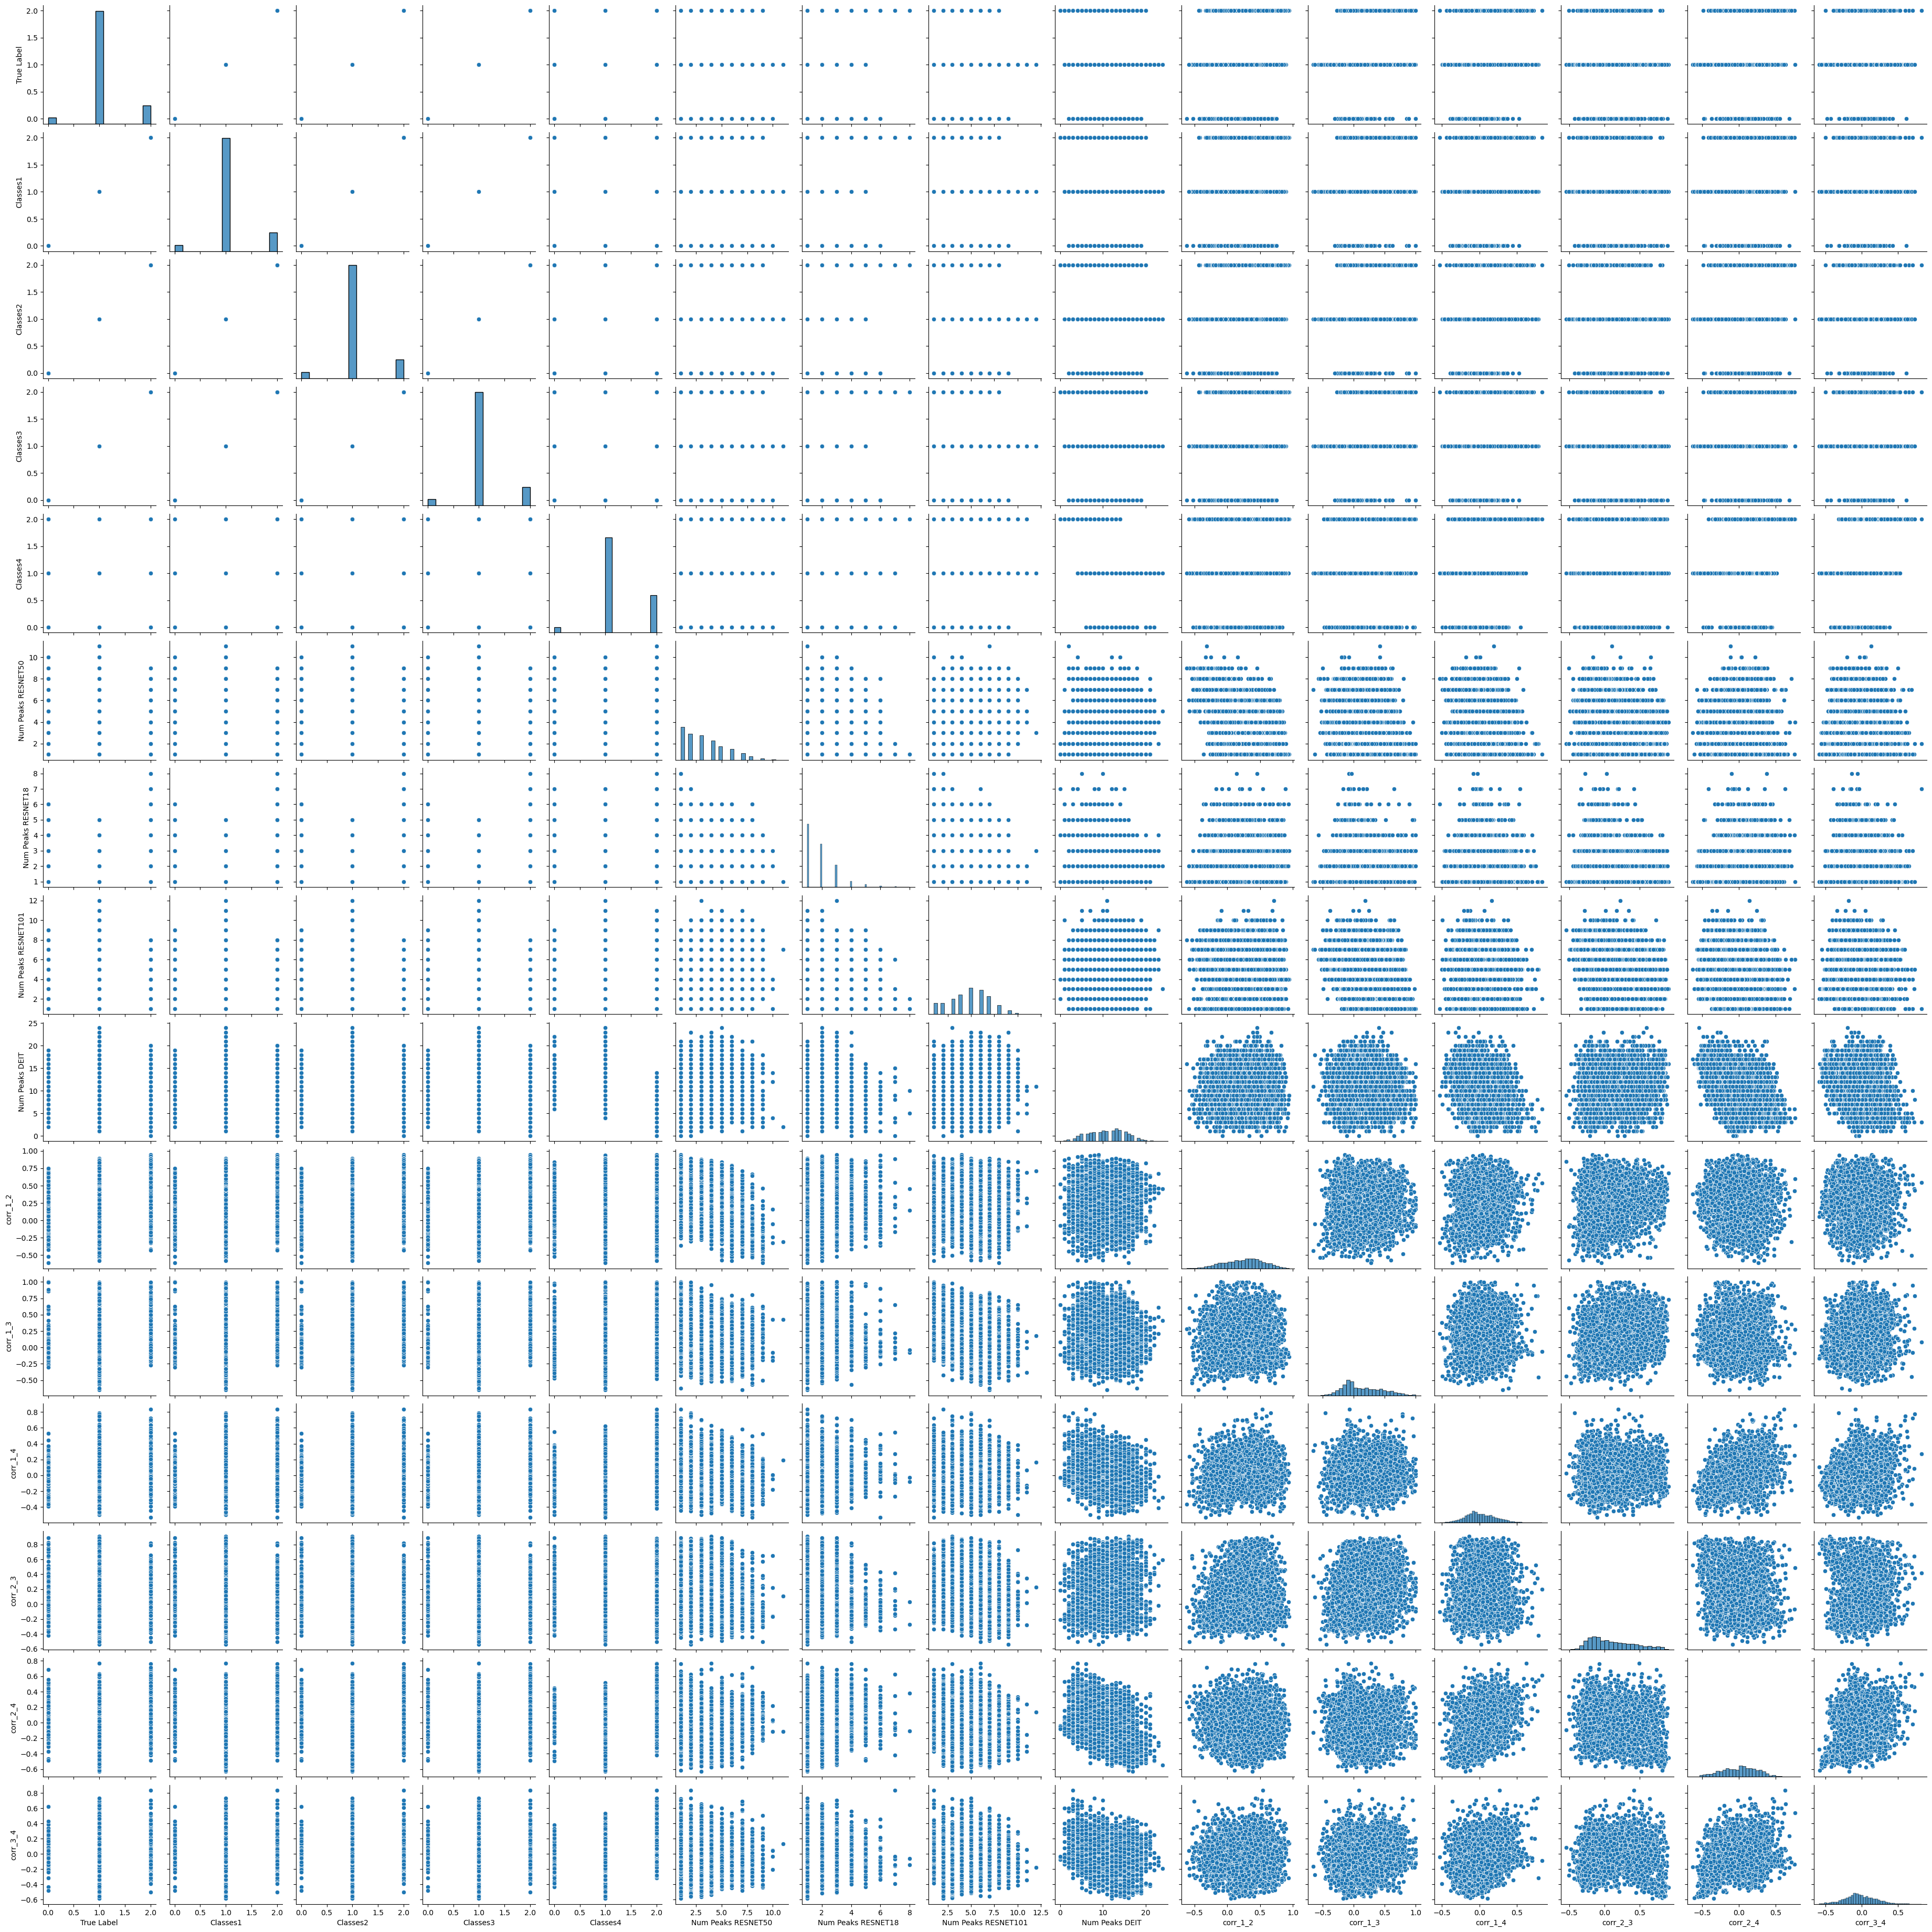

In [23]:
sns.pairplot(matching_cases_df)

/tmp/ipykernel_74054/1980048111.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=combined_df, x='corr_1_2', y='Group', palette={'Consensus': 'green', 'Disensus': 'red'}, alpha=0.7)
/tmp/ipykernel_74054/1980048111.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Group')


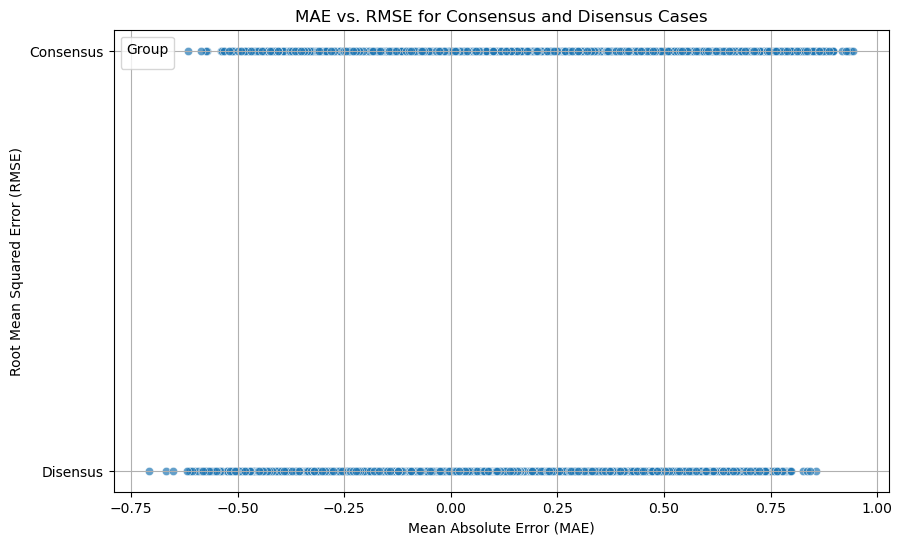

In [26]:
# Create consensus_df and disensus_df
matching_cases = (df_val['Classes1'] == df_val['Classes2']) & \
                 (df_val['Classes1'] == df_val['Classes3'])
consensus_df = df_val[matching_cases].copy()
disensus_df = df_val[~matching_cases].copy()

# Add a new column to identify the group
consensus_df['Group'] = 'Consensus'
disensus_df['Group'] = 'Disensus'

# Combine the DataFrames
combined_df = pd.concat([consensus_df, disensus_df], ignore_index=True)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='corr_1_2', y='Group', palette={'Consensus': 'green', 'Disensus': 'red'}, alpha=0.7)

# Customize the plot
plt.title('MAE vs. RMSE for Consensus and Disensus Cases')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend(title='Group')
plt.show()

In [ ]:
print(consensus_df)
print(disensus_df)